# Object Detection w/ YOLOv3 (Darknet -> Caffe)
This tutorial demonstrates the steps required to prepare and deploy a trained YOLO-v3 model for FPGA acceleration  
We will prepare a trained YOLO v3 model, and then run a single detection.  

## Introduction
You only look once (YOLO) is a state-of-the-art, real-time object detection algorithm.  
The algorithm was published by Redmon et al. in 2016 via the following publications:
[YOLOv1](https://arxiv.org/abs/1506.02640),
[YOLOv2](https://arxiv.org/abs/1612.08242).  
[YOLOv3](https://arxiv.org/abs/1804.02767).  
This application requires more than just simple classification. The task here is to detect the presence of objects, and localize them within a frame.  
Please refer to the papers for full algorithm details, and/or watch [this.](https://www.youtube.com/watch?v=9s_FpMpdYW8) 
In this tutorial, the network was trained on the 80 class [COCO dataset.](http://cocodataset.org/#home)

## Background
The authors of the YOLO papers used their own programming framework called "Darknet" for research, and development. 
The framework is written in C, and was [open sourced.](https://github.com/pjreddie/darknet)
Additionally, they host documentation, and pretrained weights [here.](https://pjreddie.com/darknet/yolov3/)
Currently, the Darknet framework is not supported by Xilinx's ML Suite.
In this tutorial we will run the network accelerated on an FPGA using 8b quantized weights and a hardware kernel implementing a 96x32 systolic array with 5MB of image RAM. All convolutions/pools are accelerated on the FPGA fabric, while the yolo layers and non-max suppression functions are executed on the CPU.  
 

# Model Preparation (Offline Process, Performed Once):

## Phase 1: Setup (Before Running Notebook)
    * source $MLSUITE_ROOT/overlaybins/setup.sh

## Phase 2: Get a Caffe Model for YOLOv3
    * Xilinx Porvides the caffe converted model for YOLOV3
    * This is necessary for integration into the downstream components of ML-Suite.  
                                                                          
## Phase 3: Quantize The Model
    * The Quantizer will generate a quantize_info.txt file holding parameters for quantizing floats to INT8
    * This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve faster inference
      * While floating point precision is useful in the model training scenario
          It is not required for high speed, high accuracy inference
          
## Phase 4: Compile The Model  
    * A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled along with the quantize_info that is generated in the prevoius step    
    * The network is optimized
    * FPGA Instructions are generated
      * These instructions are required to run the network in "one-shot", and minimize data movement
    * This step also generates a quantizer.json which has channel-wise parameters to carry out fixed point operations accross channels and layers


    
 

### Step 1. Import required packages, check environment.

In [1]:
import os,sys,cv2,numpy,timeit
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

# Bring in Xilinx ML-Suite Compiler and Quantizer
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from decent import CaffeFrontend as xfdnnQuantizer
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

# Bring in darknet2caffe functions
from xfdnn.rt.scripts.framework.darknet.darknet2caffe import *
from get_decent_q_prototxt import *

# Bring in Non-Max Suppression 
import nms

# Bring in utility for drawing boxes
from yolo_utils import process_all_yolo_layers, apply_nms ,sortSecond, generate_colors, draw_boxes

# Environment Variables ("source overlaybins/setup.sh")
import os
HOME = os.getenv("HOME","/home/mluser")
MLSUITE_ROOT = os.getenv("MLSUITE_ROOT","../")
MLSUITE_PLATFORM = os.getenv("MLSUITE_PLATFORM","alveo-u200")
os.environ['LIBXDNN_PATH'] = MLSUITE_ROOT+"/xfdnn/rt/libs/libxfdnn.so.v3" # Use only XDNNv3

print("Running w/ MLSUITE_ROOT: %s" % MLSUITE_ROOT)
print("Running w/ MLSUITE_PLATFORM: %s" % MLSUITE_PLATFORM)
print("Running w/ LIBXDNN_PATH: %s" % os.environ['LIBXDNN_PATH'])

-f
Running w/ MLSUITE_ROOT: /opt/arun/MLsuite_fork
Running w/ MLSUITE_PLATFORM: alveo-u250
Running w/ LIBXDNN_PATH: /opt/arun/MLsuite_fork/xfdnn/rt/libs/libxfdnn.so.v3


### Step 2. Use a config dictionary to pass parameters. Load an image from disk.

Here, we will setup and use a config dictionary to simplify handling of the arguments. For this example, we will attempt to classify a picture of a man standing on a horse. Image courtesy of openimages.


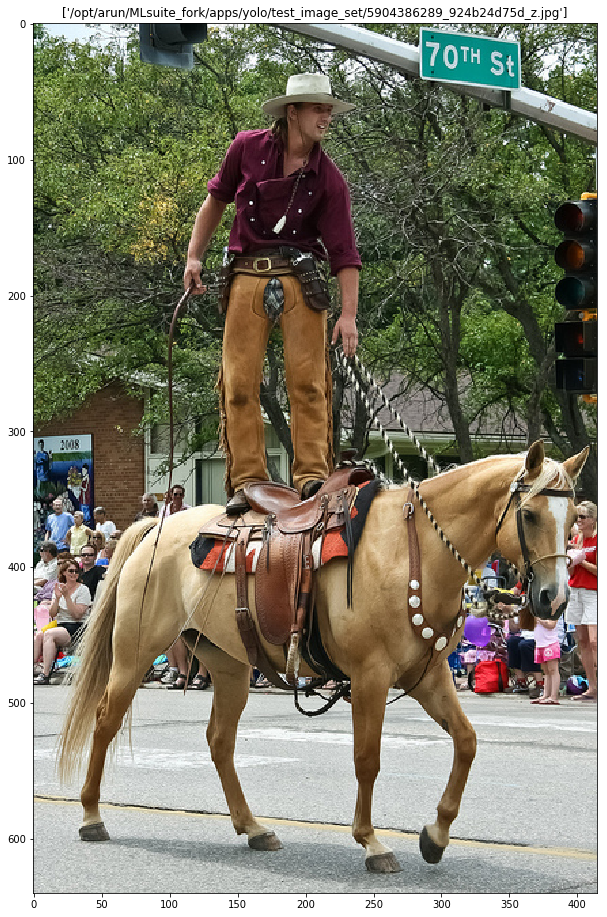

In [2]:
config = {}

# Image of interest (Must provide as a list)
config["images"] = [MLSUITE_ROOT+"/apps/yolo/test_image_set/5904386289_924b24d75d_z.jpg"]
config['in_shape'] = [3, 608, 608]

img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title(config["images"])
plt.show()

### Step 3. Get a Caffe Model for YOLOv3

In [3]:
## Download Model From Xilinx.com
#!cd $MLSUITE_ROOT && \
#wget https://www.xilinx.com/bin/public/openDownload?filename=models.darknet.yolov2_2019-05-02_12_32.zip -O temp.zip && \
#unzip -o temp.zip
##
  
# Run conversion
config["prototxt"] = MLSUITE_ROOT+"/models/caffe/yolov3/fp32/yolo_v3_standard_608.prototxt" 
config["caffemodel"] = MLSUITE_ROOT+"/models/caffe/yolov3/fp32/yolo_v3_standard.caffemodel" 


### Step 4. Create Quantizer Instance and pass arguments.

Here, we will quantize the model. The inputs are model train_val prototxt, model weights, number of test iterations and calibration iterations. The output is quantized prototxt, weights, and quantize_info.txt and will be generated in the quantize_results/ directory.

The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT8 This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve accelerated inference

In [ ]:
#We need to generate a train val prototxt from depoly prototxt
get_train_prototxt_deephi("caffe", 
                          config["prototxt"] , 
                          "train_val.prototxt",
                          MLSUITE_ROOT+"/apps/yolo/images.txt", 
                          MLSUITE_ROOT+"/apps/yolo/test_image_set/")

In [5]:
# Use a config dictionary to pass parameters to the compiler
# Quantizer Arguments
#config["outmodel"] = Defined in Step 4 # String for naming intermediate prototxt, caffemodel
def Quantize(prototxt,caffemodel,calib_iter=1):
    
    quantizer = xfdnnQuantizer(
        model=prototxt,
        weights=caffemodel,
        calib_iter=calib_iter,
    )
    
    quantizer.quantize()

In [6]:
Quantize("train_val.prototxt",config["caffemodel"])

### Step 5. Define an xfdnnCompiler instance and pass it arguments.  
The compiler takes in the quantizer outputs from the previous step (prototxt, weights, quantize_info) and outputs a compiler.json and quantizer.json.

* A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
* The network is optimized
* FPGA Instructions are generated
  

In [7]:
# Some standard compiler arguments - PLEASE DONT TOUCH
def Getopts():
    return {
            "bytesperpixels":1,
            "dsp":96,
            "memory":9,
            "ddr":256,
            "cpulayermustgo":True,
            "mixmemorystrategy":True,
            "pipelineconvmaxpool":True,
            "usedeephi":True,
    }

In [8]:
def Compile(prototxt="quantize_results/deploy.prototxt",\
            caffemodel="quantize_results/deploy.caffemodel",\
            quantize_info="quantize_results/quantize_info.txt"):
    
    compiler = xfdnnCompiler(        
        networkfile=prototxt,
        weights=caffemodel,
        quant_cfgfile=quantize_info,
        generatefile="work/compiler",
        quantz="work/quantizer",
        **Getopts()
    )
    
    compiler.compile()


In [ ]:
Compile()
config["quantizecfg"] = "work/quantizer.json"
config["netcfg"]      = "work/compiler.json"
config["weights"]     = "work/deploy.caffemodel_data.h5"

# Model Deployment (Online Process, Typically Performed Iteratively):  
    

## Phase 4. Deploy The Model.
Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run region layer on the CPU
7. Run non-max suppression on the CPU
8. Print the result 
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use overlay_4. You can learn about other overlay options in the ML Suite Tutorials [here][].  

[here]: https://github.com/Xilinx/ml-suite
        
### Step 6. Open a handle for FPGA communication.

In [10]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by pyxfdnn

# Chosen Hardware Overlay
config["xclbin"] = MLSUITE_ROOT+"/overlaybins/"+MLSUITE_PLATFORM+"/overlay_4.xclbin"
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

config["xfdnn_library"] = MLSUITE_ROOT+"/xfdnn/rt/xdnn_cpp/lib/libxfdnn.so.v3" # Library functions called by pyXFDNN

config['xdnn_handle'], handles = pyxfdnn.createHandle(config['xclbin'], "kernelSxdnn_0" )
if config['xdnn_handle'] != 0:
    print("ERROR: Unable to create handle to FPGA")
    

else:
    print("INFO: Successfully created handle to FPGA")
    
# If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware
# For instance the xclbin could have been built for the wrong DSA/shell

INFO: Successfully created handle to FPGA


### Step 7. Apply quantization scaling and transfer model weights to the FPGA. 

In [11]:
# Quantize, and transfer the weights to FPGA DDR

# config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
config["scaleA"] = 10000 # Global scaler for weights (Must be defined, although not used)
config["scaleB"] = 30 # Global scaler for bias (Must be defined, although not used)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements
config['batch_sz']=1
#(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)

# Note that this function returns pointers to weights corresponding to the layers that will be implemented in the CPU

### Step 8. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [12]:
#initialize network
fpgaRT = pyxfdnn.XDNNFPGAOp(handles, config)
fpgaInput = fpgaRT.getInputs()
fpgaOutput = fpgaRT.getOutputs()

firstInput = fpgaInput.itervalues().next()
firstOutput = fpgaOutput.itervalues().next()
    
# Allocate space in host memory for inputs, Load images from disk



In [13]:
firstInput[0,...], s = pyxfdnn_io.loadYoloImageBlobFromFile(img,  config['in_shape'][1], config['in_shape'][2])

### Step 9. Set parameters for outputs.

In [14]:
# Allocate space in host memory for outputs

# The output of a yolo network is more complex than most networks.

# In YOLOv2 the input image is square, and it is divided into grid cells of 32 pixels each.
# For example, a 608x608 image would yield a volume with HxW = 19x19. Where 19 = 608/32
#              a 224x224 image would yield a volume with HxW = 7x7
out_h = out_w = config["in_shape"][1] / 32

# For each grid cell in the input image, YOLOv2 considers the possibility of 5 objects being present (Anchor Boxes)
#   For each anchor box, YOLOv2 computes
#   - The probability that there is an object in the anchor box - 1 element
#   - The x,y,w,h coordinates of a bounding box (centroid and width height of box) - 4 elements
#   - The class probabilities (Number of classes depends on dataset) We use MS COCO which has 80 classes - 80 elements
config['anchorCnt'] = 3
config['classes']   = 80


 


          

### Step 10. Write optimized micro-code to the xDNN Processing Engine on the FPGA. Execute the network.

In [ ]:
# Write FPGA Instructions to FPGA and Execute the network!
startTime = timeit.default_timer()
fpgaRT.execute(fpgaInput, fpgaOutput, config['PE'])
elapsedTime = timeit.default_timer() - startTime
           
# Only showing time for second run because first is loading script
#log.info("\nTotal FPGA: %f ms" % (elapsedTime*1000))
#log.info("Image Time: (%f ms/img):" % (elapsedTime*1000/config['batch_sz']))
print("Time to load microcode and execute %d ms" % (elapsedTime*1000))
    
# Note that the time printed here is the time to transfer microcode to the FPGA + the time to execute
# Iterative calls to this cell will produce the real latency number
fpgaOutput_list = [fpgaOutput.items()[0][1], fpgaOutput.items()[1][1], fpgaOutput.items()[2][1]]



### Step 11. Execute the YOLO layers on the CPU.
The Yolo layer requires the sigmoid function to be applied to the X/Y coordinates of each prediction, and the box confidence. .

In [16]:
# Functions Required for implementing YOLO layer
# Implemented using numpy in a numerically stable manner
def yolo_layer(fpgaOutput_list,  config):
    
    anchorCnt = config['anchorCnt']
    classes =  config['classes']   
    # execute core yolo layer
    out_yolo_layers = process_all_yolo_layers(fpgaOutput_list, classes, anchorCnt, config['in_shape'][2], config['in_shape'][1])
    

    
    # Reformat data to generate box detections
    num_proposals_layer=[0]
    total_proposals = 0
    for layr_idx in range (len(out_yolo_layers)):
        yolo_layer_shape = out_yolo_layers[layr_idx].shape
        #print "layr_idx , yolo_layer_shape", layr_idx , yolo_layer_shape
        out_yolo_layers[layr_idx] = out_yolo_layers[layr_idx].reshape(yolo_layer_shape[0], anchorCnt, (5+classes), yolo_layer_shape[2]*yolo_layer_shape[3])
        out_yolo_layers[layr_idx] = out_yolo_layers[layr_idx].transpose(0,3,1,2)
        out_yolo_layers[layr_idx] = out_yolo_layers[layr_idx].reshape(yolo_layer_shape[0],yolo_layer_shape[2]*yolo_layer_shape[3] * anchorCnt, (5+classes))           
        #print "layr_idx, final in layer sape, outlayer shape", layr_idx, yolo_layer_shape, out_yolo_layers[layr_idx].shape
        total_proposals += yolo_layer_shape[2]*yolo_layer_shape[3] * anchorCnt
        num_proposals_layer.append(total_proposals)
        
    boxes_array = np.empty([config['batch_sz'], total_proposals, (5+classes)])
    
    
    for layr_idx in range (len(out_yolo_layers)):
        proposal_st = num_proposals_layer[layr_idx]
        proposal_ed = num_proposals_layer[layr_idx + 1]
        #print "proposal_st proposal_ed", proposal_st, proposal_ed
        boxes_array[:,proposal_st:proposal_ed,:] = out_yolo_layers[layr_idx][...]
    
    return boxes_array


startTime = timeit.default_timer()    
boxes_array = yolo_layer(fpgaOutput_list,  config)
elapsedTime = timeit.default_timer() - startTime

print(elapsedTime*1000, "ms")

59.3030452728 ms


### Step 12. Execute NMS on the CPU.
Non-Max Suppression is the algorithim used to filter out redundant predictions. For instance, yolo could have produced multiple bounding boxes for the same object. Additionally, predictions made with low confidence are thrown out.

In [17]:
# Perform Non-Max Suppression
# Non-Max Suppression filters out detections with a score lesser than 0.24
# Additionally if there are two predections with an overlap > 30%, the prediction with the lower score will be filtered

def correct_region_boxes(boxes_array, x_idx, y_idx, w_idx, h_idx, w, h, net_w, net_h):
    
    new_w = 0;
    new_h = 0;
    #print "x_idx, y_idx, w_idx, h_idx, w, h, net_w, net_h", x_idx, y_idx, w_idx, h_idx, w, h, net_w, net_h
    if ((float(net_w) / float(w)) < (float(net_h) / float(h))) :
        new_w = net_w
        new_h = (h * net_w) / w
    else:
        new_w = (w * net_h) / h;
        new_h = net_h
    
    boxes_array[:,x_idx] = (boxes_array[:,x_idx] - (net_w - new_w) / 2.0 / net_w) / (float(new_w) / net_w);
    boxes_array[:,y_idx] = (boxes_array[:,y_idx] - (net_h - new_h) / 2.0 / net_h) / (float(new_h) / net_h);
    boxes_array[:,w_idx] *= float(net_w) / float(new_w);
    boxes_array[:,h_idx] *= float(net_h) / float(new_h);
    
    return boxes_array

scorethresh = 0.24
config['iouthresh'] = 0.3
boxes_array[0,:,:] = correct_region_boxes(boxes_array[0,:,:], 0, 1, 2, 3, float(s[1]), float(s[0]), float(config['in_shape'][2]), float(config['in_shape'][1]))
detected_boxes = apply_nms(boxes_array[0,:,:], config['classes'], config['iouthresh'])

#form a clean box list
bboxes=[]
for det_idx in range(len(detected_boxes)):
        bboxes.append({'classid' : detected_boxes[det_idx][4],
                     'prob' : detected_boxes[det_idx][5],
                     'll' : {'x' : int((detected_boxes[det_idx][0] - 0.5 *detected_boxes[det_idx][2]) *s[1]),
                             'y' : int((detected_boxes[det_idx][1] + 0.5 *detected_boxes[det_idx][3]) * s[0])},
                     'ur' : {'x' : int((detected_boxes[det_idx][0] + 0.5 *detected_boxes[det_idx][2]) * s[1]),
                             'y' : int((detected_boxes[det_idx][1] - 0.5 *detected_boxes[det_idx][3]) * s[0])}})

### Step 13. Print out results.
After NMS all operations are complete. Now we must print the results, and we can draw the detections on the original image for reference.

oimage = 5904386289_924b24d75d_z.jpg
Saving new image with bounding boxes drawn as ./work/5904386289_924b24d75d_z.jpg


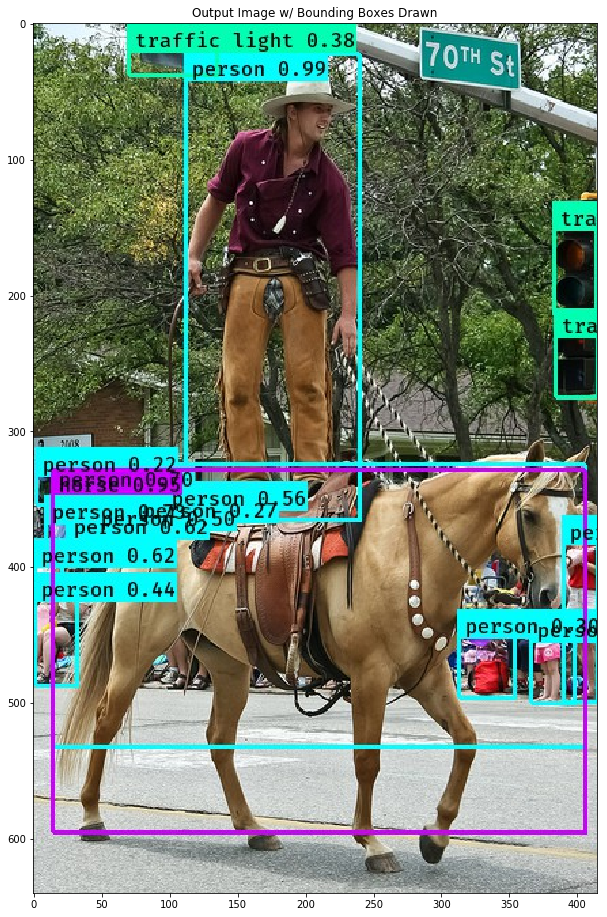

In [18]:
# Create a list of class labels given a file containing the coco dataset classes
with open(MLSUITE_ROOT+"/apps/yolo/coco.names") as f:      
    namez = f.readlines()      
    names = [x.strip() for x in namez]
    
   
# Given the detection results above, lets draw our findings on the original image, and display it
colors = generate_colors(config["classes"])
draw_boxes(config["images"][0],bboxes,names,colors,"./work",MLSUITE_ROOT+"/apps/yolo/font",False)
outimage = "./work/" + os.path.basename(config["images"][0])
img = cv2.imread(outimage)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title("Output Image w/ Bounding Boxes Drawn")
plt.show()

In [19]:
# Lets print the detections our model made
for j in range(len(bboxes)):
    print("Obj %d: %s\ class id = %d" % (j, names[bboxes[j]['classid']], bboxes[j]['classid']))
    print("\t score = %f" % (bboxes[j]['prob']))
    print("\t (xlo,ylo) = (%d,%d)" % (bboxes[j]['ll']['x'], bboxes[j]['ll']['y']))
    print("\t (xhi,yhi) = (%d,%d)" % (bboxes[j]['ur']['x'], bboxes[j]['ur']['y']))
    

Obj 0: person\ class id = 0
	 score = 0.988939
	 (xlo,ylo) = (111,364)
	 (xhi,yhi) = (239,21)
Obj 1: person\ class id = 0
	 score = 0.851348
	 (xlo,ylo) = (389,498)
	 (xhi,yhi) = (414,362)
Obj 2: person\ class id = 0
	 score = 0.730943
	 (xlo,ylo) = (8,387)
	 (xhi,yhi) = (30,347)
Obj 3: person\ class id = 0
	 score = 0.703185
	 (xlo,ylo) = (13,531)
	 (xhi,yhi) = (405,323)
Obj 4: person\ class id = 0
	 score = 0.677870
	 (xlo,ylo) = (365,499)
	 (xhi,yhi) = (397,434)
Obj 5: person\ class id = 0
	 score = 0.622383
	 (xlo,ylo) = (0,420)
	 (xhi,yhi) = (20,379)
Obj 6: person\ class id = 0
	 score = 0.621892
	 (xlo,ylo) = (24,390)
	 (xhi,yhi) = (45,358)
Obj 7: person\ class id = 0
	 score = 0.561778
	 (xlo,ylo) = (96,362)
	 (xhi,yhi) = (113,337)
Obj 8: person\ class id = 0
	 score = 0.499898
	 (xlo,ylo) = (44,383)
	 (xhi,yhi) = (61,352)
Obj 9: person\ class id = 0
	 score = 0.436434
	 (xlo,ylo) = (0,486)
	 (xhi,yhi) = (31,404)
Obj 10: person\ class id = 0
	 score = 0.301544
	 (xlo,ylo) = (312

### Step 14. Close the handle.

In [20]:
pyxfdnn.closeHandle()

# C'est fini!